# AlexNet

## 发展

- 核函数：凸优化定理，漂亮的定理
- 几何学：传统计算机视觉（CNN通常用于计算机视觉），良好的数学解
- 特征工程：从原始图片中提取特征
    - 特征描述子：SIFT，SURF
    
**问题**：

- ImageNet:
    - 自然物体的彩色物体
    - 469x387
    - 样本数：1.2M
    - 类别：1000 (~5000 per class)
    
## AlexNet

- 更大更深的`LeNet`
- 改进：
    - 丢弃法
    - ReLU
    - MaxPooling（最大值：让梯度变大）
- 观念改变：从`人工特征提取+SVM`到`CNN+Softmax`
    - 特征提取和训练同时，端到端的预测
    
### 架构

- Input : 3x224x244  `3@224x224`
- Conv : 96 @ Kernel 11x11 stride 4  `96@54x54`
- Pool : MaxPool 3x3, stride 2  `96@26x26`
- Conv : 256 @ Kernel 5x5 pad 2  `256@26x26`
- Pool : MaxPool 3x3, stride 2  `256@12x12`
- Conv : 384 @ Kernel 3x3 pad 1  `384@12x12`
- Conv : 384 @ Kernel 3x3 pad 1 `384@12x12`
- Conv : 256 @ Kernel 3x3 pad 1 `256@12x12`
- Pool : MaxPool 3x3, stride 2 `256@5x5`
- Linear : 6400
- Linear : 4096
- Linear : 1000

> 加入了数据增强

In [1]:
import torch
from torch import nn
import torchvision
import time
import os
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline

In [2]:
# 使用 FashionMINIST 1@24x24
net = nn.Sequential(
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
    nn.Linear(6400, 4096), nn.ReLU(), nn.Dropout(0.5),
    nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
    nn.Linear(4096, 10),
)

In [3]:
X = torch.rand(size=(1, 1, 224, 224), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(f"{layer.__class__.__name__} : {X.shape}")

Conv2d : torch.Size([1, 96, 54, 54])
ReLU : torch.Size([1, 96, 54, 54])
MaxPool2d : torch.Size([1, 96, 26, 26])
Conv2d : torch.Size([1, 256, 26, 26])
ReLU : torch.Size([1, 256, 26, 26])
MaxPool2d : torch.Size([1, 256, 12, 12])
Conv2d : torch.Size([1, 384, 12, 12])
ReLU : torch.Size([1, 384, 12, 12])
Conv2d : torch.Size([1, 384, 12, 12])
ReLU : torch.Size([1, 384, 12, 12])
Conv2d : torch.Size([1, 256, 12, 12])
ReLU : torch.Size([1, 256, 12, 12])
MaxPool2d : torch.Size([1, 256, 5, 5])
Flatten : torch.Size([1, 6400])
Linear : torch.Size([1, 4096])
ReLU : torch.Size([1, 4096])
Dropout : torch.Size([1, 4096])
Linear : torch.Size([1, 4096])
ReLU : torch.Size([1, 4096])
Dropout : torch.Size([1, 4096])
Linear : torch.Size([1, 10])


/usr/local/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [4]:
resize = 224
batch_size=256
num_cpu_cores = os.cpu_count()
trans = [torchvision.transforms.ToTensor()]
if resize is not None:
    trans.insert(0, torchvision.transforms.Resize(resize))
trans = torchvision.transforms.Compose(trans)
train_iter = torch.utils.data.DataLoader(torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=trans), batch_size, shuffle=True, num_workers=num_cpu_cores)
test_iter = torch.utils.data.DataLoader(torchvision.datasets.FashionMNIST(root="./data", train=False, download=True, transform=trans), batch_size, shuffle=True, num_workers=num_cpu_cores)


/usr/local/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
""" 累加器对象 """
class Accumulator: # 累加器对象
    """ 在 n 个变量上累加 """
    def __init__(self, n):
        self.data = [0.0] * n # python 语法 [0]*n将n个list连接在一起

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        # zip() 将迭代器打包成元组

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, index):
        return self.data[index]

""" 与真实值对比 """
def accuracy(y_hat, y):
    """ 分类问题，统计正确个数 """
    # y_hat 是二维矩阵，取每一行的最大值
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # 返回最大值对应的序号
    cmp = y_hat.type(y.dtype) == y   # 保证 y 和 y_hat 类型相同
    # cmp 是 bool 类型
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy_gpu(net, data_iter):
    """使用GPU计算模型在数据集上的精度"""
    device = try_gpu() 
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def try_gpu(i = 0):
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f"cuda:{i}")
    else:
        return torch.device('cpu')
    

def train_gpu(net, train_iter, test_iter, num_epochs, lr):
    device = try_gpu()
    print(f'training on {device}')

    def init_weight(m):
        if type(m) == torch.nn.Linear or type(m) == torch.nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
    net.apply(init_weight)

    net.to(device)
    optimizer = torch.optim.SGD(params=net.parameters(), lr=lr)
    loss = torch.nn.CrossEntropyLoss()
    
    train_l, train_acc, test_acc, time_l = [], [], [], []

    for epoch in range(num_epochs):
        metric = Accumulator(3)
        net.train()
        start = time.perf_counter()
        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat=y_hat, y=y), X.shape[0])
        end = time.perf_counter()
        train_l.append(metric[0] / metric[2])
        train_acc.append(metric[1] / metric[2])
        test_acc.append(evaluate_accuracy_gpu(net, test_iter))
        time_l.append(end-start)
        print(f"Epoch {epoch+1}, Using Time : {time_l[-1]:.3f}, train_acc : {train_acc[-1]:.4f} test_acc : {test_acc[-1]:.4f}")
    """绘图"""
    backend_inline.set_matplotlib_formats("svg")
    plt.rcParams['figure.figsize']=(7, 5)
    plt.plot(list(range(num_epochs)), train_l, 'm--')
    plt.plot(list(range(num_epochs)), train_acc, 'r:')
    plt.plot(list(range(num_epochs)), test_acc, 'g-')

    plt.legend(["train_loss", "train_accuracy", "test_accuracy"])
    plt.xlabel('epochs')
    plt.ylabel('percent')
    plt.title(f'{num_epochs} epochs')
    plt.grid(True)

    print(f"Test accuracy : {test_acc[-1]:.3f}")
    print(f'{metric[2] * num_epochs / sum(time_l):.1f} examples/sec on {str(torch.cuda.get_device_name())}')

training on cuda:0
Epoch 1, Using Time : 36.185, train_acc : 0.5783 test_acc : 0.7609
Epoch 2, Using Time : 36.369, train_acc : 0.7958 test_acc : 0.7967
Epoch 3, Using Time : 36.575, train_acc : 0.8370 test_acc : 0.8286
Epoch 4, Using Time : 36.765, train_acc : 0.8557 test_acc : 0.7696
Epoch 5, Using Time : 37.013, train_acc : 0.8694 test_acc : 0.8383
Epoch 6, Using Time : 36.868, train_acc : 0.8772 test_acc : 0.8605
Epoch 7, Using Time : 36.853, train_acc : 0.8842 test_acc : 0.8856
Epoch 8, Using Time : 36.942, train_acc : 0.8921 test_acc : 0.8934
Epoch 9, Using Time : 36.818, train_acc : 0.8963 test_acc : 0.8953
Epoch 10, Using Time : 36.857, train_acc : 0.8996 test_acc : 0.8830
Epoch 11, Using Time : 36.912, train_acc : 0.9050 test_acc : 0.8820
Epoch 12, Using Time : 36.979, train_acc : 0.9078 test_acc : 0.8898
Epoch 13, Using Time : 36.902, train_acc : 0.9108 test_acc : 0.8907
Epoch 14, Using Time : 36.872, train_acc : 0.9141 test_acc : 0.9020
Epoch 15, Using Time : 36.914, train_a

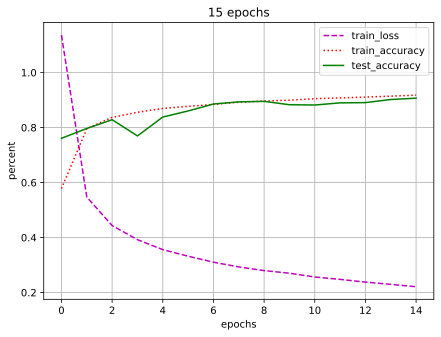

In [6]:
lr, num_epochs = 0.05, 15
start = time.perf_counter()
train_gpu(net, train_iter, test_iter, num_epochs, lr)
end = time.perf_counter()
print(f"Total Time : {end-start:3f}")

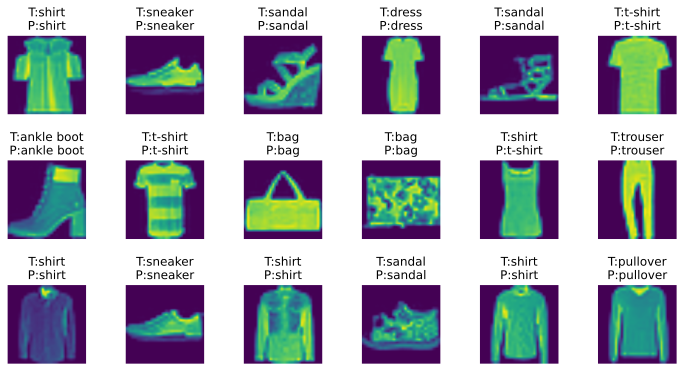

In [8]:
""" 获得标签索引对应文本"""
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', \
                 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

""" 打印图片 """
def show_img(imgs, num_rows, num_cols, title=None, scale=1.5):
    figsize = (num_cols * scale, num_rows * scale)
    plt.rcParams["figure.figsize"] = figsize
    for i in range(num_rows * num_cols):
        plt.subplot(num_rows, num_cols, i+1)
        plt.title(title[i])
        plt.axis('off')
        if torch.is_tensor(imgs[i].numpy()):
            plt.imshow(imgs[i].numpy())
        else:
            plt.imshow(imgs[i])

def predtic_ch3(net, test_iter, rows, cols):
    n = rows * cols
    for X, y in test_iter:
        break
    net.to(torch.device('cpu'))
    trues = get_fashion_mnist_labels(y)
    predicts = get_fashion_mnist_labels(net(X).argmax(axis=1))
    title = [f"T:{true}\nP:{predict}" for true, predict in zip(trues, predicts)]
    show_img(X[0:n].reshape([n, 224, 224]), rows, cols, title=title[0:n], scale=2)
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    
predtic_ch3(net, test_iter, 3, 6)

## QA

- 最后两个4096x4096 是很重要的
    - 可以认为CNN的深度不够，需要MLP进一步提取
- 特征增强不一定可以提高精度